# iToF - indirect time of flight

Oddan signal **T**: $$T = I * \sin{(2\pi f_m t)}$$
Modulirni signal **S**: $$S = \sin{(2\pi f_m t)}$$
Odbit signal **R**: $$R = \delta * I * \sin{(2\pi f_m t - \Delta\varphi)} + A$$

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from numba import jit

In [87]:
@jit
def get_modulated_signals(t, f, d, I=0.5, dI=1):
    """Returns the transmitted, reflected and modulated signals.
    
    Parameters
    ----------
    t : numpy.ndarray
        Time values for which the signal should be calculated
    f : float
        Frequency of the transmitted signal
    I : float
        Amplitude of transmitted signal
    d : float
        Distance between transmitter and the obstacle
    dI : float
        Amplitude change of the reflected signal
        
    Returns
    -------
    numpy.ndarray
        Transmitted signal
    numpy.ndarray
        Reflected signal
    numpy.ndarray
        0 phase shifted modulated signal
    numpy.ndarray
        90 degree phase shifted modulated signal
    numpy.ndarray
        180 degree phase shifted modulated signal
    numpy.ndarray
        270 degree phase shifted modulated signal
    """
    # Transmitted signal
    s_t = I * np.sin(2 * np.pi * f * t)

    # Reflected signal
    # Phase change of the reflected signal
    dP = 2 * np.pi * f * 2 * d / const.c  
    s_r = dI * I * np.sin(2 * np.pi * f * t + dP)

    # Modulated signals
    s_m_0 = np.sin(2 * np.pi * f * t)
    s_m_90 = np.sin(2 * np.pi * f * t + np.pi / 2)
    s_m_180 = np.sin(2 * np.pi * f * t + np.pi)
    s_m_270 = np.sin(2 * np.pi * f * t + 3 * np.pi / 2)

    return s_t, s_r, s_m_0, s_m_90, s_m_180, s_m_270

In [88]:
def int_indexes(x, a, b):
    idx_a = np.argmin(np.abs(x - a))
    idx_b = np.argmin(np.abs(x - b))
    return idx_a, idx_b

In [89]:
# Time axis
t_ns = np.arange(0, 1e3, 1e-3)
t_s = t_ns / 1e9

In [96]:
# Parameters
f_m = 1e7           # Frequency of the transmitted signal
I = 5               # Amplitude of transmitted signal
d = 30               # distance between transmitter and the obstacle
dI = 0.5            # Amplitude ch# Parameters
f_m = 1e7           # Frequency of the transmitted signal

# Calculated parameters
wl = const.c / f_m  # Wavelength
Tp = 1 / f_m        # Time period between two pulses
dP = (2 * np.pi * f_m * 2 * d / const.c + np.pi) % (2 * np.pi)  # Phase change of the reflected signal

print("Wavelength: {:.2f} m".format(wl))
print("Time interval between two pulses: {:.2f} ns".format(Tp * 1e9))
print("Phase change of the reflected signal: {:.2f} rad".format(dP))

Wavelength: 29.98 m
Time interval between two pulses: 100.00 ns
Phase change of the reflected signal: 3.15 rad


In [108]:
def test_distance():
    dP = (2 * np.pi * f_m * 2 * d / const.c + np.pi) % (2 * np.pi)  # Phase change of the reflected signal
    s_t, s_r, s_m_0, s_m_90, *_ = get_modulated_signals(t_s, f_m, d, I)

    s_rs = s_r * s_m_0 # Product of the reflected and 0 phase modulated signal
    s_r90s = s_r * s_m_90 # Product of the reflected and 90 phase modulated signal


    T_int = Tp # Whole number of time periods between two pulses

    # Integration of the product of the reflected and modulated signals
    ia, ib = int_indexes(t_s, 0, T_int)
    s_rs_int = np.trapz(s_rs[ia:ib], t_s[ia:ib])
    s_r90s_int = np.trapz(s_r90s[ia:ib], t_s[ia:ib])

    dP_calc = np.arctan(s_r90s_int / s_rs_int) # calculated phase change of the reflected signal
    d_calc = dP_calc * const.c / (4 * np.pi * f_m) # calculated distance between transmitter and the obstacle

    print("distance: {:.2f} m".format(d))
    print("\tCalculated phase change: {:.2f} [{:.2f}] rad".format(dP_calc, dP))
    print("\tCalculated distance: {:.2f} [{:.2f}] m".format(d_calc, d))


def plot_signals():
    s_t, s_r, s_m_0, s_m_90, *_ = get_modulated_signals(t_s, f_m, d, I)
    lim = 100

    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.plot(t_ns, s_t, label="Transmitted signal", color="blue")
    plt.plot(t_ns, s_r, label="Reflected signal", color="red")
    plt.xlim(0, lim)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(222)
    plt.plot(t_ns, s_m_0, label="0 phase modulated signal", color="green")
    plt.plot(t_ns, s_m_90, label="90 phase modulated signal", color="lightgreen")
    plt.xlim(0, lim)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(212)
    plt.xlim(0, lim)
    plt.plot(t_ns, s_rs, label="Reflected and 0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns, s_r90s, label="Reflected and 90 phase modulated signal", color="orange")
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()


    plt.tight_layout()
    plt.show()

distance: 3.00 m
	Calculated phase change: 1.26 [4.40] rad
	Calculated distance: 3.00 [3.00] m


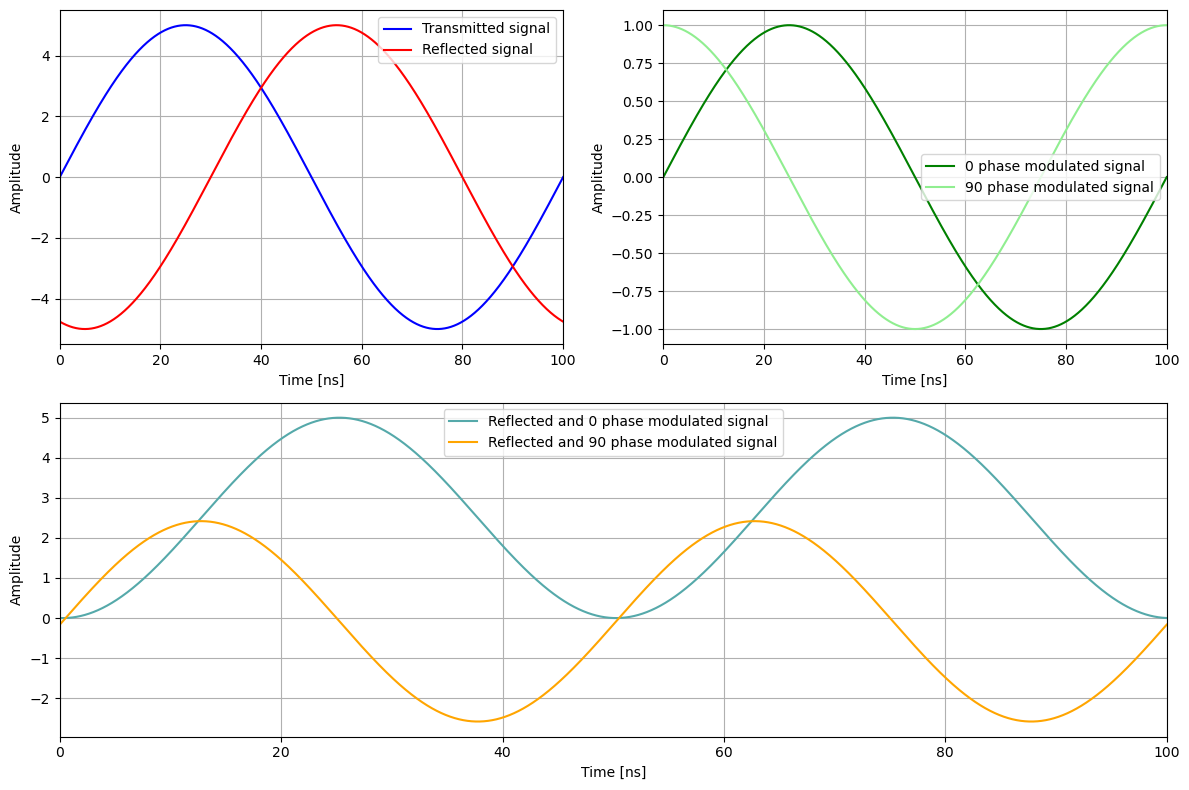

In [111]:
d = 3
test_distance()
plot_signals()

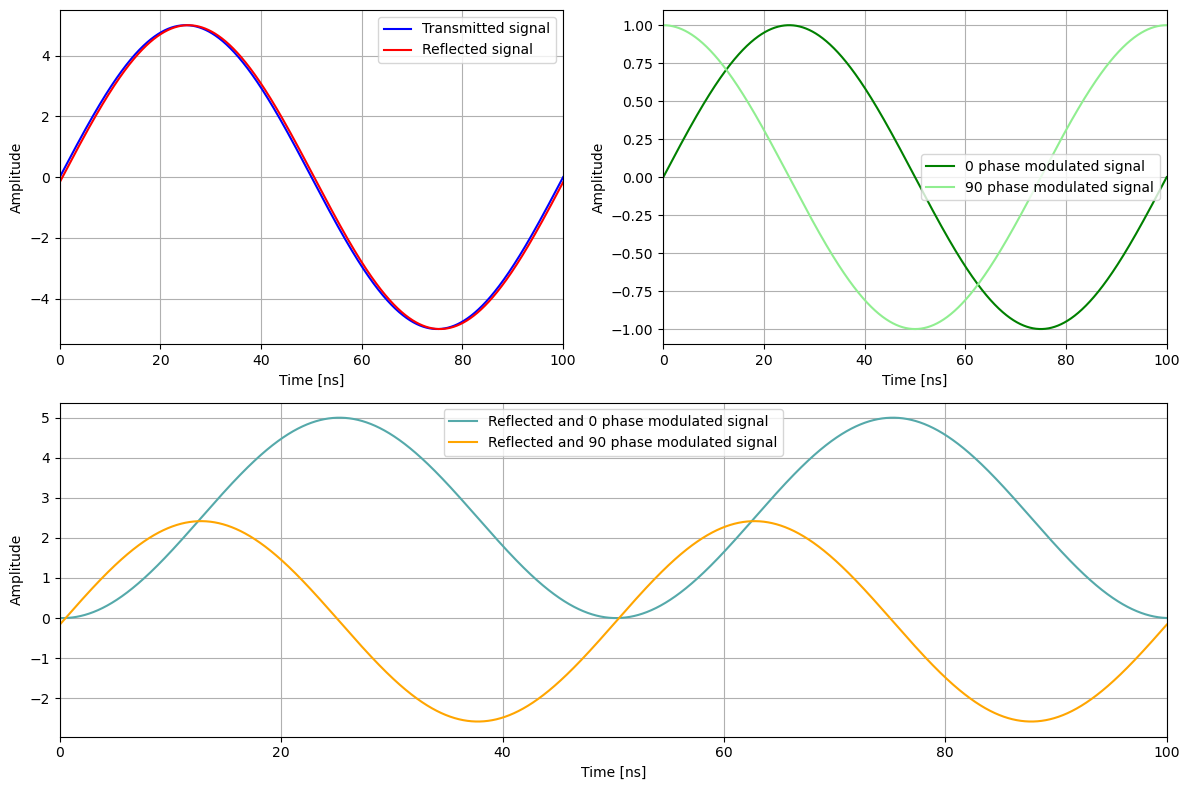

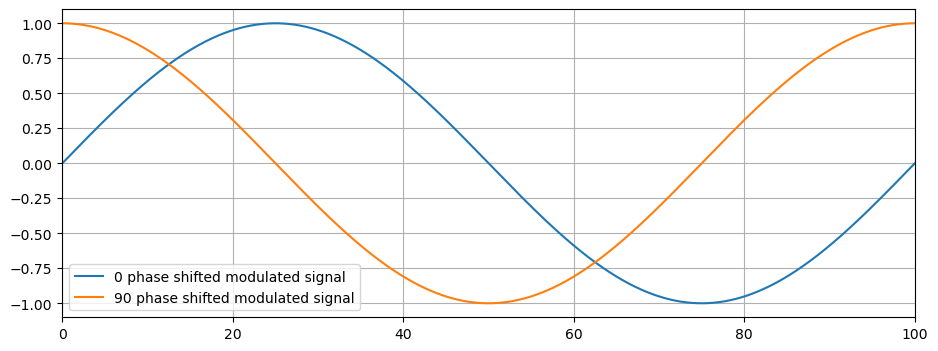

In [94]:
plt.figure(figsize=(11, 4))
plt.grid(True)
plt.xlim(0, lim)
plt.plot(t_ns, s_m_0, label="0 phase shifted modulated signal")
plt.plot(t_ns, s_m_90, label="90 phase shifted modulated signal")
plt.legend()
plt.show()

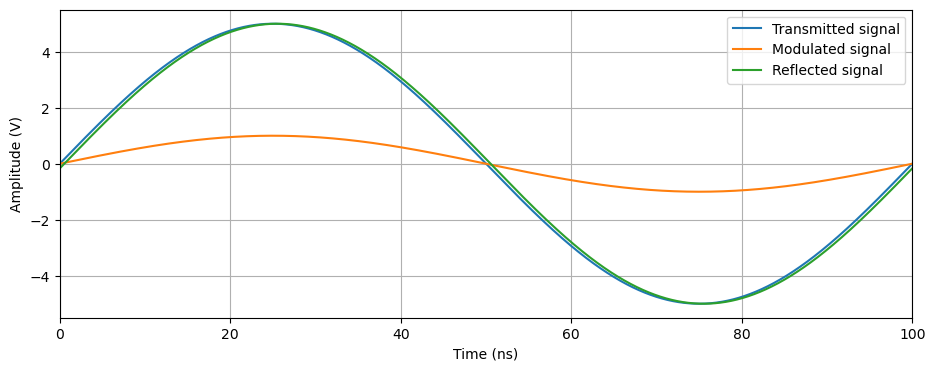

In [95]:
plt.figure(figsize=(11, 4))

plt.xlim(0, lim)

plt.plot(t_ns, s_t, label='Transmitted signal')
plt.plot(t_ns, s_m_0, label='Modulated signal')
plt.plot(t_ns, s_r, label='Reflected signal')
plt.grid()
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.show()